<a href="https://colab.research.google.com/github/teedonk/Fraud-Detection/blob/main/fraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define dataset path
dataset_path = Path('/content/drive/My Drive/fraud_detection')

# Load datasets
train_data = pd.read_csv(dataset_path / 'train.csv')
test_data = pd.read_csv(dataset_path / 'test.csv')

# Display basic info
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
train_data.head()


Train Data Shape: (150000, 32)
Test Data Shape: (69129, 31)


,id,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount,IsFraud
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


Class Distribution:
IsFraud
0    149731
1       269
Name: count, dtype: int64


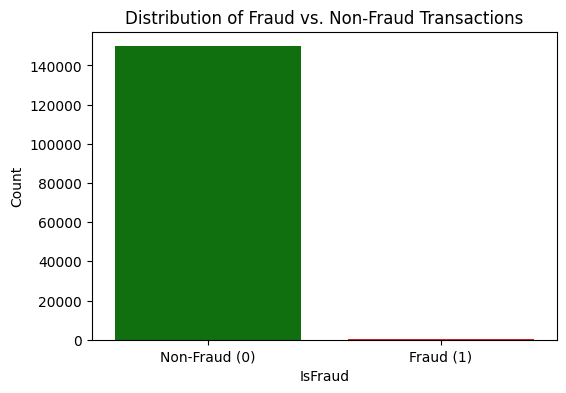

In [4]:
# Class distribution of fraud and non-fraud transactions
fraud_counts = train_data["IsFraud"].value_counts()

print("Class Distribution:")
print(fraud_counts)

# Visualizing the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["Non-Fraud (0)", "Fraud (1)"])
plt.ylabel("Count")
plt.title("Distribution of Fraud vs. Non-Fraud Transactions")
plt.show()


Balanced Class Distribution:
IsFraud
0    74865
1    74865
Name: count, dtype: int64


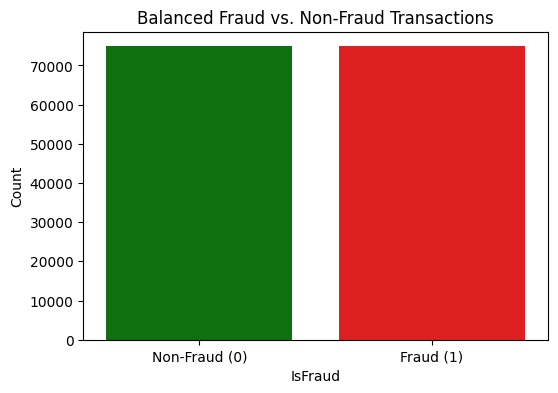

In [5]:
# Separate features and target variable
X = train_data.drop(columns=["IsFraud", "id", "Time"])  # Drop non-relevant columns
y = train_data["IsFraud"]

# Oversample the minority class (fraud cases)
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)  # 50% fraud class
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Undersample the majority class (non-fraud cases)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Equal fraud & non-fraud
X_balanced, y_balanced = undersampler.fit_resample(X_resampled, y_resampled)

# Print new class distribution
balanced_counts = y_balanced.value_counts()
print("Balanced Class Distribution:")
print(balanced_counts)

# Visualizing the new distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=balanced_counts.index, y=balanced_counts.values, palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["Non-Fraud (0)", "Fraud (1)"])
plt.ylabel("Count")
plt.title("Balanced Fraud vs. Non-Fraud Transactions")
plt.show()


In [6]:
# Set random seed for reproducibility
RANDOM_SEED = 42

# Feature extraction: Selecting relevant features (excluding id and Time)
features = [col for col in train_data.columns if col not in ["IsFraud", "id", "Time"]]

# Assign the new dataframe (Balanced Data)
df_balanced = pd.DataFrame(X_balanced, columns=features)
df_balanced["IsFraud"] = y_balanced  # Add the target variable back

# Scaling features using StandardScaler
scaler = StandardScaler()
df_balanced[features] = scaler.fit_transform(df_balanced[features])

# Prepare training data
X_final = df_balanced[features]
y_final = df_balanced["IsFraud"]

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=RANDOM_SEED, stratify=y_final)

# Print shape of final datasets
print(f"Training Data Shape: {X_train.shape}, Validation Data Shape: {X_val.shape}")


Training Data Shape: (119784, 29), Validation Data Shape: (29946, 29)


In [7]:
# Initialize models with parameters optimized for probabilistic predictions
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
lr_model = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
xgb_model = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss", random_state=42
)


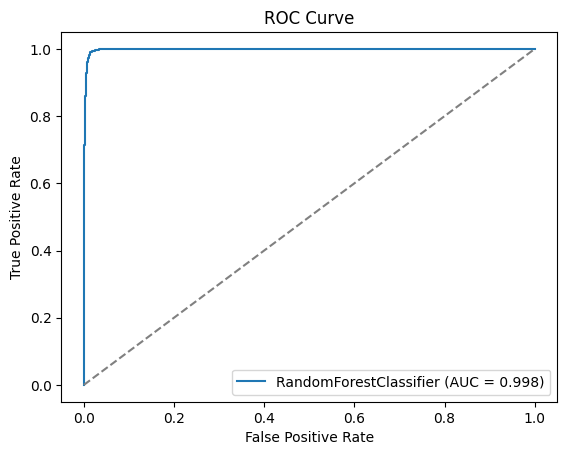

RandomForestClassifier ROC-AUC Score: 0.998


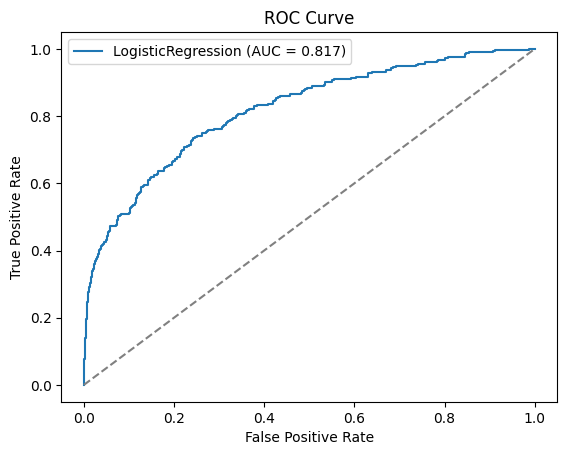

LogisticRegression ROC-AUC Score: 0.817


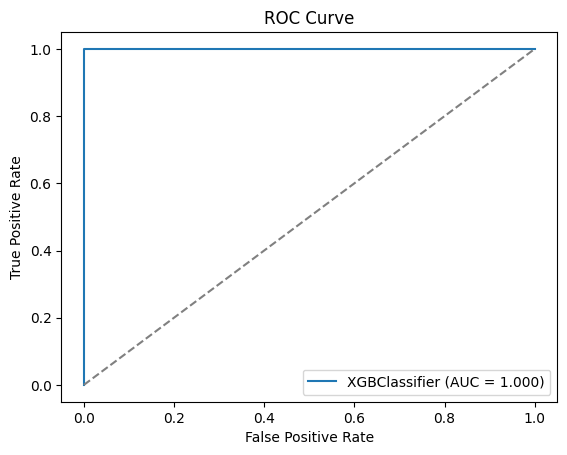

XGBClassifier ROC-AUC Score: 1.000


In [8]:
# Function to evaluate models using ROC-AUC
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)  # Train the model
    y_probs = model.predict_proba(X_val)[:, 1]  # Get probability scores for the positive class
    roc_auc = roc_auc_score(y_val, y_probs)  # Compute ROC-AUC score

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print(f"{model.__class__.__name__} ROC-AUC Score: {roc_auc:.3f}")

# Evaluate models (Random Forest, Logistic Regression, and XGBoost)
evaluate_model(rf_model, X_train, y_train, X_val, y_val)
evaluate_model(lr_model, X_train, y_train, X_val, y_val)
evaluate_model(xgb_model, X_train, y_train, X_val, y_val)


XGBoost ROC-AUC Score: 1.000
Random Forest ROC-AUC Score: 0.998
Logistic Regression ROC-AUC Score: 0.817


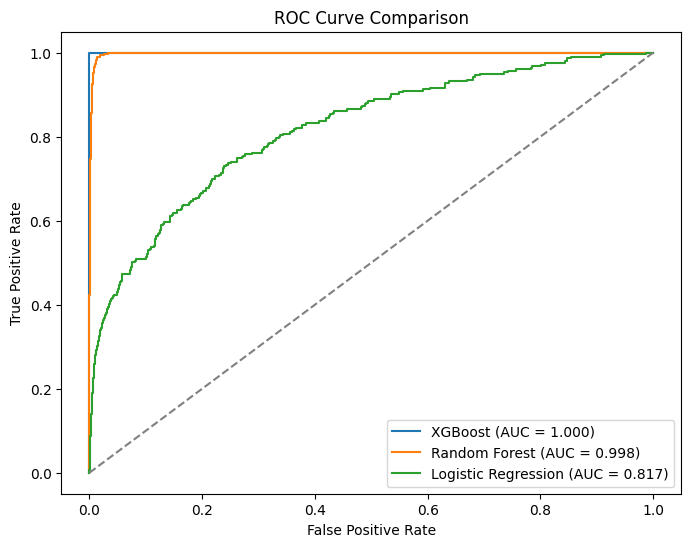

In [9]:
# Train and evaluate multiple models
models = {
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced"),
    "Logistic Regression": LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
}

# Function to train, evaluate and compare models
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predict probabilities for the positive class
        y_probs = model.predict_proba(X_val)[:, 1]

        # Compute ROC-AUC score
        roc_auc = roc_auc_score(y_val, y_probs)
        print(f"{name} ROC-AUC Score: {roc_auc:.3f}")

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_val, y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    # Plot random baseline
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.show()

# Train and evaluate all models
train_and_evaluate(models, X_train, y_train, X_val, y_val)


In [10]:
test_data.head()

,id,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount
0,150000,73899,-0.681234,-0.371212,0.385966,0.955703,2.064078,0.338827,-0.539452,-0.254046,...,0.183560,-0.253324,0.266668,-0.153829,0.455969,-0.503628,0.257588,-0.456685,-0.298919,30.42
1,150001,73899,-1.098947,-0.959377,0.324934,0.703908,1.090582,-1.595909,0.584548,0.260069,...,0.334764,0.130108,0.676928,-0.161070,-0.638011,-0.273424,0.711132,0.349967,0.141233,23.00
2,150002,73899,0.977029,-0.270984,0.471526,-1.232570,0.957537,-0.636602,-0.953060,-1.491744,...,0.355728,0.517912,1.175087,-0.325895,-0.362636,0.306037,0.004828,0.037389,0.058222,198.00
3,150003,73900,1.176658,-0.225816,-0.246600,0.015513,1.103831,1.229516,-1.527098,-0.459769,...,-0.152613,-0.104600,0.003800,-0.023180,-0.458338,0.481427,-0.381415,0.080165,0.027372,9.99
4,150004,73900,0.804828,-0.272967,0.959910,-1.117567,0.395748,0.589855,1.059880,-1.101203,...,-0.127818,-0.011849,0.078540,-0.241700,0.010130,0.302614,-0.259568,0.023127,0.056957,239.00


In [11]:
# Ensure the best model (XGBoost) is trained
best_model = xgb_model  # XGBoost was the best-performing model

# Scale the test features using the same scaler from training data
X_test_scaled = scaler.transform(test_data.drop(columns=["id", "Time"]))

# Predict fraud probabilities using the trained XGBoost model
test_data["IsFraud"] = best_model.predict_proba(X_test_scaled)[:, 1]  # Probability of fraud

# Keep only 'id' and 'IsFraud' columns
submission = test_data[["id", "IsFraud"]]

# Define the path to save the predictions
output_file_path = "/content/drive/My Drive/fraud_detection/fraud_predictions.csv"

# Save the submission file
submission.to_csv(output_file_path, index=False)

print(f"Submission file saved to {output_file_path}")

Submission file saved to /content/drive/My Drive/fraud_detection/fraud_predictions.csv


In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Preprocessing: Remove 'id' and 'Time' before training
X_train_unbalanced = train_data.drop(columns=["id", "Time", "IsFraud"], errors="ignore")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unbalanced)

# Train Isolation Forest (Unsupervised Anomaly Detection)
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
iso_forest.fit(X_train_scaled)

# Predict on test data
X_test_unbalanced = test_data.drop(columns=["id", "Time", "IsFraud"], errors="ignore")  # ✅ Fix applied
X_test_scaled = scaler.transform(X_test_unbalanced)

test_data["IsFraud"] = iso_forest.predict(X_test_scaled)

# Convert anomaly scores: -1 → Fraud (1), 1 → Non-Fraud (0)
test_data["IsFraud"] = test_data["IsFraud"].map({-1: 1, 1: 0})

# Save submission file
submission = test_data[["id", "IsFraud"]]
output_file_path = "/content/drive/My Drive/fraud_detection/anomaly_fraud_predictions.csv"
submission.to_csv(output_file_path, index=False)

print(f"Anomaly detection fraud predictions saved to {output_file_path}")


Anomaly detection fraud predictions saved to /content/drive/My Drive/fraud_detection/anomaly_fraud_predictions.csv


In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Remove non-feature columns
X_train_unbalanced = train_data.drop(columns=["id", "Time", "IsFraud"], errors="ignore")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unbalanced)

# Split into training & validation
X_train, X_val = train_test_split(X_train_scaled, test_size=0.2, random_state=42)

# Define Autoencoder
input_dim = X_train.shape[1]
autoencoder = keras.Sequential([
    Dense(input_dim, activation="relu"),
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(32, activation=LeakyReLU()),  # More neurons
    BatchNormalization(),  # Normalize activations
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(32, activation=LeakyReLU()),
    BatchNormalization(),
    Dense(input_dim, activation="sigmoid")
])

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), verbose=1)

# Compute reconstruction error
train_reconstructions = autoencoder.predict(X_train)
train_mse = np.mean(np.square(train_reconstructions - X_train), axis=1)

# Set threshold for fraud detection
threshold = np.percentile(train_mse, 95)  # Top 5% as fraud

# Predict on test data
X_test_unbalanced = test_data.drop(columns=["id", "Time", "IsFraud"], errors="ignore")
X_test_scaled = scaler.transform(X_test_unbalanced)
test_reconstructions = autoencoder.predict(X_test_scaled)

# Compute reconstruction error
test_mse = np.mean(np.square(test_reconstructions - X_test_scaled), axis=1)
test_data["IsFraud"] = (test_mse > threshold).astype(int)  # Label frauds

# Save submission file
submission = test_data[["id", "IsFraud"]]
output_file_path = "/content/drive/My Drive/fraud_detection/autoencoder_fraud_predictions.csv"
submission.to_csv(output_file_path, index=False)

print(f"Autoencoder fraud predictions saved to {output_file_path}")


Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.9672 - val_loss: 0.7725
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7760 - val_loss: 0.7515
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.7787 - val_loss: 0.7371
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7856 - val_loss: 0.7303
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7691 - val_loss: 0.7325
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7569 - val_loss: 0.7252
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7405 - val_loss: 0.7204
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7552 - val_loss: 0.7168
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7425 - val_loss: 0.7177
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7459 - val_loss: 0.7141
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.7544 - val_loss: 0.7132
Epoch 12/50
1875/1875 ━━━━

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Step 1: Load and Filter Non-Fraud Transactions
non_fraud_data = train_data[train_data["IsFraud"] == 0].drop(columns=["id", "Time", "IsFraud"])

# Step 2: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(non_fraud_data)

# Step 3: Build Autoencoder Model
input_dim = X_train_scaled.shape[1]
autoencoder = keras.Sequential([
    Dense(32, activation="relu", input_shape=(input_dim,)),
    Dropout(0.2),  # Prevent overfitting
    Dense(16, activation="relu"),
    BatchNormalization(),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(32, activation="relu"),
    Dense(input_dim, activation="sigmoid")  # Output same shape as input
])

autoencoder.compile(optimizer="adam", loss="mse")

# Step 4: Train Autoencoder on Non-Fraud Data
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.1, verbose=1)

# Step 5: Compute Reconstruction Error for Fraud Detection
train_reconstructions = autoencoder.predict(X_train_scaled)
train_mse = np.mean(np.power(X_train_scaled - train_reconstructions, 2), axis=1)

# Step 6: Set Fraud Detection Threshold (95th percentile)
threshold = np.percentile(train_mse, 95)
print(f"Reconstruction Error Threshold: {threshold}")

# Step 7: Prepare Test Data (Exclude "id", "Time" & "IsFraud")
X_test_unbalanced = test_data.drop(columns=["id", "Time", "IsFraud"], errors="ignore")  # Explicitly remove "IsFraud"
X_test_scaled = scaler.transform(X_test_unbalanced)

# Step 8: Predict on Test Data
test_reconstructions = autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_reconstructions, 2), axis=1)

# Step 9: Label Fraud Transactions (Above Threshold)
test_data["IsFraud"] = (test_mse > threshold).astype(int)

# Step 10: Save Submission File
submission = test_data[["id", "IsFraud"]]
submission.to_csv("/content/drive/My Drive/fraud_detection/autoencoder_predictions.csv", index=False)

print("✅ Fraud predictions saved!")


Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 1.0455 - val_loss: 0.8004
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8422 - val_loss: 0.7636
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8180 - val_loss: 0.7468
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8029 - val_loss: 0.7372
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8017 - val_loss: 0.7312
Epoch 6/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8022 - val_loss: 0.7264
Epoch 7/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7795 - val_loss: 0.7227
Epoch 8/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7759 - val_loss: 0.7196
Epoch 9/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7717 - val_loss: 0.7157
Epoch 10/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7700 - val_loss: 0.7119
Epoch 11/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7627 - val_loss: 0.7088
Epoch 12/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st